In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import requests
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
def read_csv(url, sep=','):
    key = url
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key="+key
    response = requests.get(api_url)
    download_url = response.json()['href']
    df = pd.read_csv(download_url, sep=sep)
    return df

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения.

1. В первую очередь, его интересует показатель **retention**. Надо написать функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных необходимо определить, **какой набор можно считать лучшим и на основе каких метрик** стоит принять правильное решение.

# Задание 1

Retention – один из самых важных показателей в компании. Необходимо написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). При этом функцию можно тестировать на части данных (каком-то определенном промежутке времени)

Данные о регистрациях: https://disk.yandex.ru/d/Xn78-_wgoIT6dA  
Данные об аутентификациях: https://disk.yandex.ru/d/BxnJZSKyNVQt_A

In [30]:
reg = read_csv('https://disk.yandex.ru/d/Xn78-_wgoIT6dA', sep = ';')
auth = read_csv('https://disk.yandex.ru/d/BxnJZSKyNVQt_A', sep = ';')

Проведем **исследование данных**.

In [31]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [100]:
reg.duplicated().sum()

0

In [32]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [99]:
auth.duplicated().sum()

0

In [39]:
# Переведем дату в соответвующий формат
reg.reg_ts = pd.to_datetime(reg.reg_ts, unit='s')
auth.auth_ts = pd.to_datetime(auth.auth_ts, unit='s')

In [40]:
auth.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [41]:
reg.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [42]:
reg_auth = pd.merge(auth, reg, on = 'uid', how = 'left')

In [76]:
reg_auth['month_auth'] = reg_auth.auth_ts.dt.date
reg_auth['month_reg'] = reg_auth.reg_ts.dt.date

In [80]:
reg_per_month = reg_auth.groupby('month_reg').uid.nunique()
auth_per_month = reg_auth.groupby('month_auth').uid.nunique()

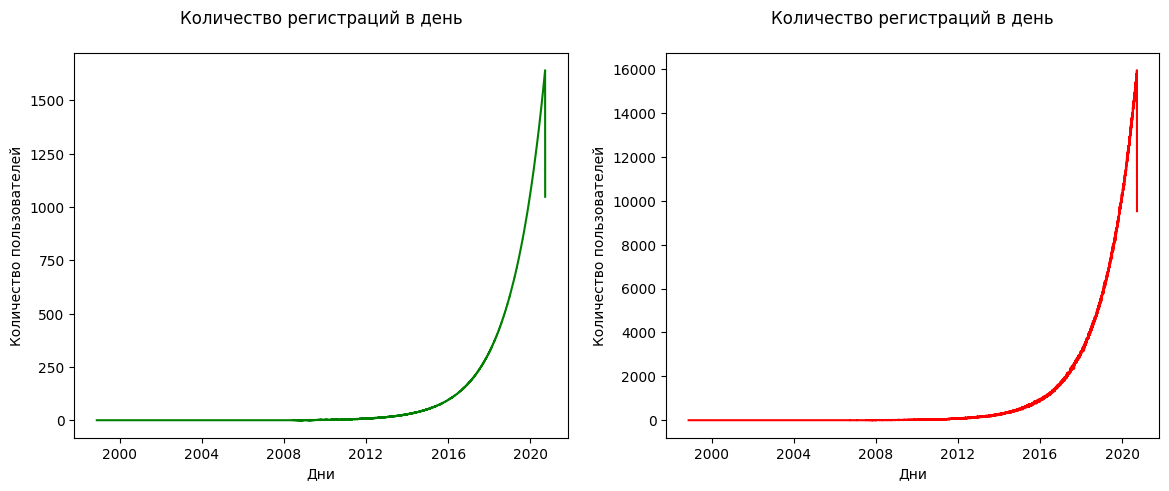

In [95]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
reg_per_month.plot(color = 'g')
plt.title('Количество регистраций в день\n')
plt.ylabel('Количество пользователей')
plt.xlabel('Дни')

plt.subplot(1,2,2)
auth_per_month.plot(color = 'r')
plt.title('Количество регистраций в день\n')
plt.ylabel('Количество пользователей')
plt.xlabel('Дни')

plt.show()

Дубликаты и пропущенные значения отсутствуют  
Видно, что количество аутентификаций и регистраций пользователей растет, особенно в последние года, то есть количество пользователь со временем увеличивается. Стоит проверить метрику Retention, чтобы понять удерживаются ли клиенты в продукте.

In [3]:
def retention(url_1, url_2, date_reg_1="1998-11-18", date_reg_2="2020-09-23"):

    """
    На вход функции подается период расчета метрики Retention, а также ссылка на данные с Яндекс диска
    """
    # Записываем данные о регистрации и аутентификации в переменные
    problem1_reg = read_csv(url_1, sep = ';')
    problem1_auth = read_csv(url_2, sep = ';')

    # Объединяем датасеты в один
    total_users = pd.merge(left = problem1_auth, right=problem1_reg, on ='uid', how='left')
    
    #Необходимо перевести время в формат datetime
    total_users.auth_ts = pd.to_datetime(total_users['auth_ts'], unit='s')
    total_users.reg_ts = pd.to_datetime(total_users['reg_ts'], unit='s')

    # Отбираем только ту часть данных, которая задана в функции
    #total_users_date = total_users.query('(reg_ts >= @date_reg_1 & reg_ts <= @date_reg_2) & \
     #                                     (auth_ts >= @date_reg_1 & auth_ts <= @date_reg_2)')

    filtration = (
        (total_users['reg_ts'] >= pd.to_datetime(date_reg_1)) &
        (total_users['reg_ts'] <= pd.to_datetime(date_reg_2)) &
        (total_users['auth_ts'] >= pd.to_datetime(date_reg_1)) &
        (total_users['auth_ts'] <= pd.to_datetime(date_reg_2))
    )

    total_users_date = total_users[filtration].copy()

    # Когортами будем считать время регистрации пользователей (так как это его первое целевое действие)
    # Оставляем только дату, вычитаем из времени аутентификации (последнего целевого действия) время регистрации (первого действия)
    total_users_date['day_reg'] = pd.to_datetime(total_users_date.reg_ts.dt.date)
    total_users_date['day_auth'] = pd.to_datetime(total_users_date.auth_ts.dt.date)
    total_users_date['timedelta'] = (total_users_date.day_auth - total_users_date.day_reg).dt.days

    # Делим пользователи на когорты, группируем по времени жизни когорты, считаем количество уникальных пользователей. 
    # Формируем сводную таблицу.
    cohort = total_users_date.groupby(['day_reg', 'timedelta'], as_index=False).uid.nunique()
    cohort_pivot = cohort.pivot(index = 'day_reg', columns = 'timedelta', values = 'uid')

    # Cчитаем размер самой длинной когорты, делим сводную таблицу на размер когорты и получаем Retention
    cohort_size = cohort_pivot[0]
    retention = cohort_pivot.divide(cohort_size, axis=0)

    # Строим график Retention
    plt.figure(figsize=(16,12))
    sns.heatmap(data = retention.iloc[:,1:],
                annot = True,
                fmt = '.1%',
                linewidth=.5,
                cmap = 'RdYlGn',
                yticklabels = retention.index.strftime('%Y-%m-%d'))

    plt.title(f"Retention за период {date_reg_1} - {date_reg_2}\n без учета даты регистрации")
    plt.ylabel('Когорты\n')
    plt.xlabel('\nДни жизни')

    plt.show()

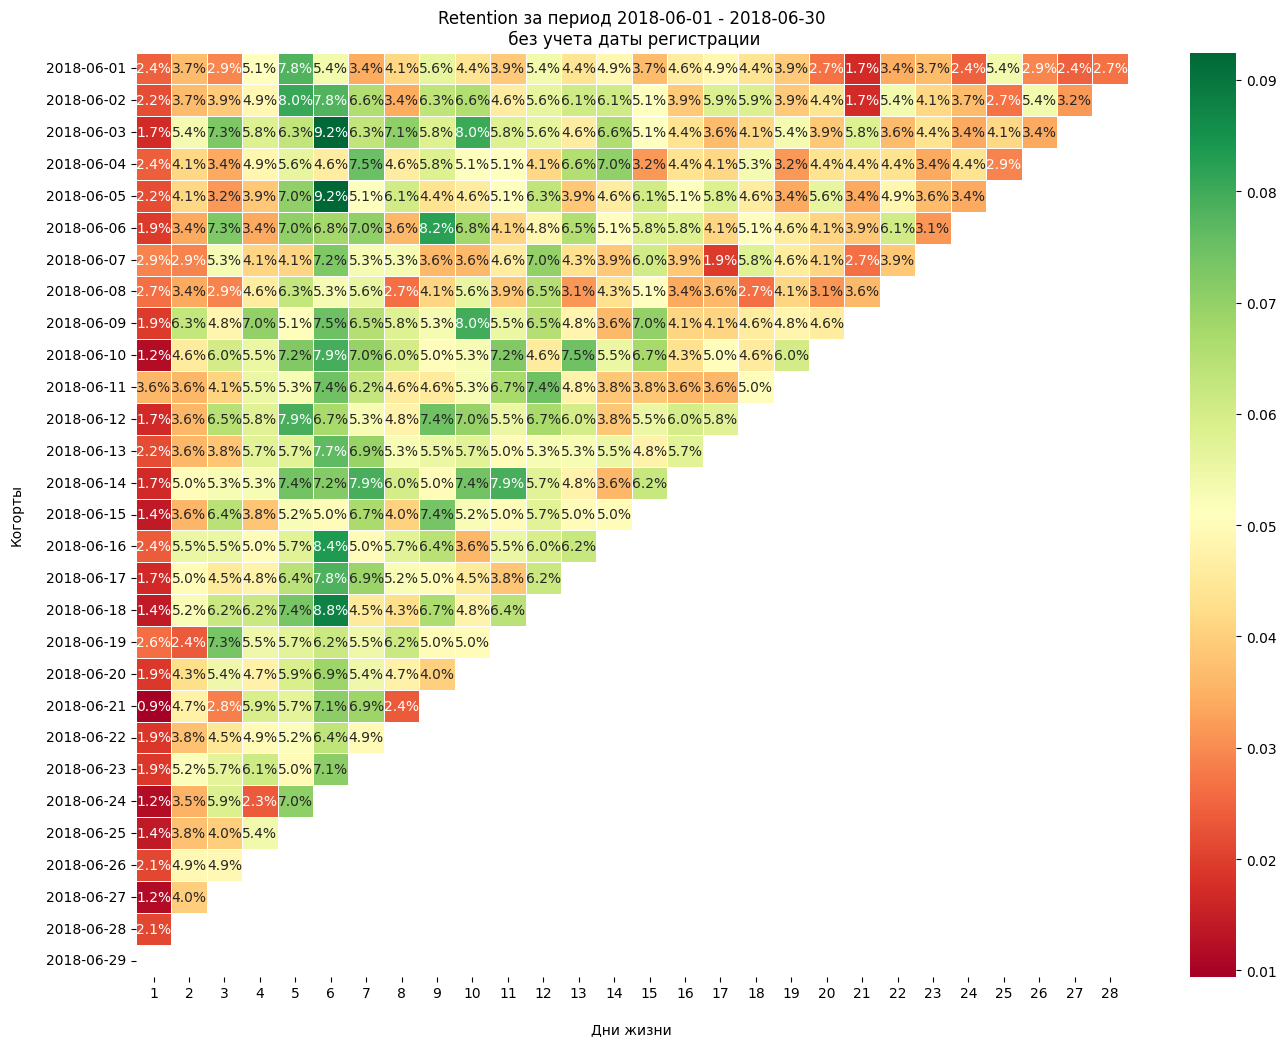

In [102]:
retention('https://disk.yandex.ru/d/Xn78-_wgoIT6dA', 'https://disk.yandex.ru/d/BxnJZSKyNVQt_A','2018-06-01', '2018-06-30')

Выводы:  
1. Retention первого дня крайне низкий. Пользователи не видят ценность в продукте и не возвращаются в него.
2. Retention 5-6 дней имеет немного более высокие показатели, чем остальные.
3. Необходимо больше данных, чтобы проверить пути удержания пользователей и сделать рекомендации по улучшению отдельных метрик

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [5]:
data = read_csv('https://disk.yandex.ru/d/A8et0GwqDqmX0g', sep = ';')

In [6]:
# Исследуем данные. Смотрим пустые значения, размер датасета, типы данных.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [7]:
# Проверяю не оказался ли какой-либо пользователь в двух группах сразу
data.groupby('testgroup', as_index=False).user_id.count().user_id.sum()

404770

In [8]:
# Смотрим описательные статистики в двух группах
group_a = data.query('testgroup == "a"').describe()
group_b = data.query('testgroup == "b"').describe()
describe_groups = pd.concat([group_a, group_b], axis=1, keys = ['Group_A', 'Group_B'])

In [9]:
describe_groups

Group_A                       Group_B               
             user_id        revenue        user_id        revenue
count  202103.000000  202103.000000  202667.000000  202667.000000
mean   202555.909843      25.413720  202215.564389      26.751287
std    116802.329266     920.768137  116891.926690     287.324162
min         2.000000       0.000000       1.000000       0.000000
25%    101502.500000       0.000000  100855.500000       0.000000
50%    202988.000000       0.000000  201821.000000       0.000000
75%    303559.000000       0.000000  303602.500000       0.000000
max    404769.000000   37433.000000  404770.000000    4000.000000

Замечаем разницу в стандартных отклонениях и максимальных значениях двух выборок.

In [10]:
std_dif = round(group_a.revenue['std'] / group_b.revenue['std'],2)

In [11]:
print(f"Стандартное отклонениe в контрольной группе больше чем в тестовой в {std_dif} раза")

Стандартное отклонениe в контрольной группе больше чем в тестовой в 3.2 раза


In [12]:
max_dif = round(group_a.revenue['max'] / group_b.revenue['max'], 2)

In [13]:
print(f"Максимальное значение выручки в контрольной группе больше чем в тестовой в {max_dif} раза")

Максимальное значение выручки в контрольной группе больше чем в тестовой в 9.36 раза


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


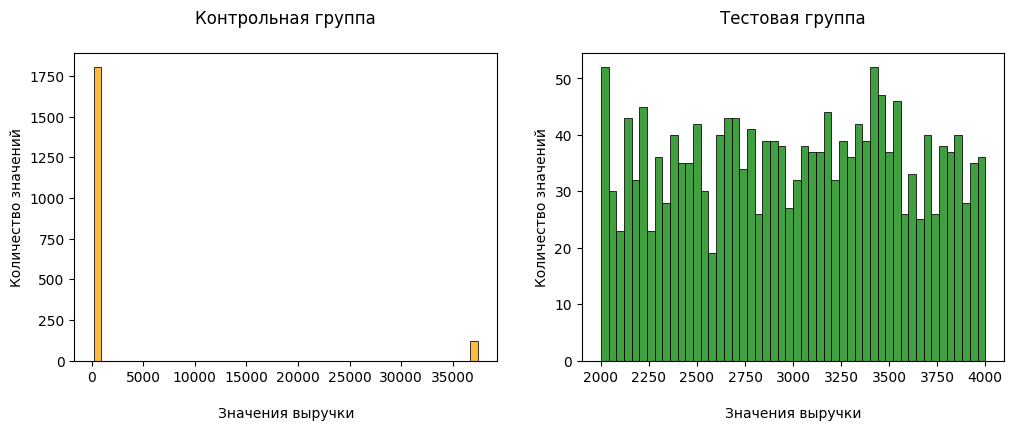

In [14]:
#Для наглядности построим графики распределения двух групп
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(data = data.query('testgroup == "a" & revenue != 0').revenue, bins = 50, color='orange')
plt.title('Контрольная группа\n')
plt.ylabel('Количество значений')
plt.xlabel('\nЗначения выручки')

plt.subplot(1,2,2)
sns.histplot(data = data.query('testgroup == "b" & revenue != 0').revenue, bins = 50, color = 'green')
plt.title('Тестовая группа\n')
plt.ylabel('Количество значений')
plt.xlabel('\nЗначения выручки')
plt.show()

#### Вывода по EDA

Проведен анализ двух выборок:  
1. Размер выборок отличается, но не значительно.
2. Стандартное отклонение в контрольной группе больше чем в тестовой в 3.2 раза.
3. Максимальное значение выручки в контрольной группе больше чем в тестовой в 9.36 раза.
4. Это означает большой разброс значений выручки в контрольной группе. Кроме того, в контрольной группе выборка сформирована неправильно. Большинство значений являются аномальными. Данная группа, как правило, не подходит для проведения дальнейшего тестирования. 

In [15]:
# Добавляем колонку с платящими и неплатящими пользователями
data['pay_users'] = data.revenue.apply(lambda x: 1 if x > 0 else 0)

In [16]:
# Группируем данные по тестовой и контрольной группам, считаем количество уникальных пользователей, платящих пользователей
# и общую выручку
data_metrics = data.groupby('testgroup', as_index=False).agg({'revenue':'sum', 'user_id':'nunique', 'pay_users':'sum'})

In [17]:
# Высчитываем метрики ARPU, ARPPU и конверсию в оплату
data_metrics['ARPU'] = data_metrics.revenue / data_metrics.user_id
data_metrics['ARPPU'] = data_metrics.revenue / data_metrics.pay_users
data_metrics['CR_pay'] = data_metrics.pay_users / data_metrics.user_id *100

In [18]:
data_metrics

,testgroup,revenue,user_id,pay_users,ARPU,ARPPU,CR_pay
0,a,5136189,202103,1928,25.413720,2663.998444,0.953969
1,b,5421603,202667,1805,26.751287,3003.658172,0.890624


/var/folders/br/yryz75s94419__57gscfgy900000gn/T/ipykernel_13288/2093335216.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{round(i*100,1)}%' for i in yticks])


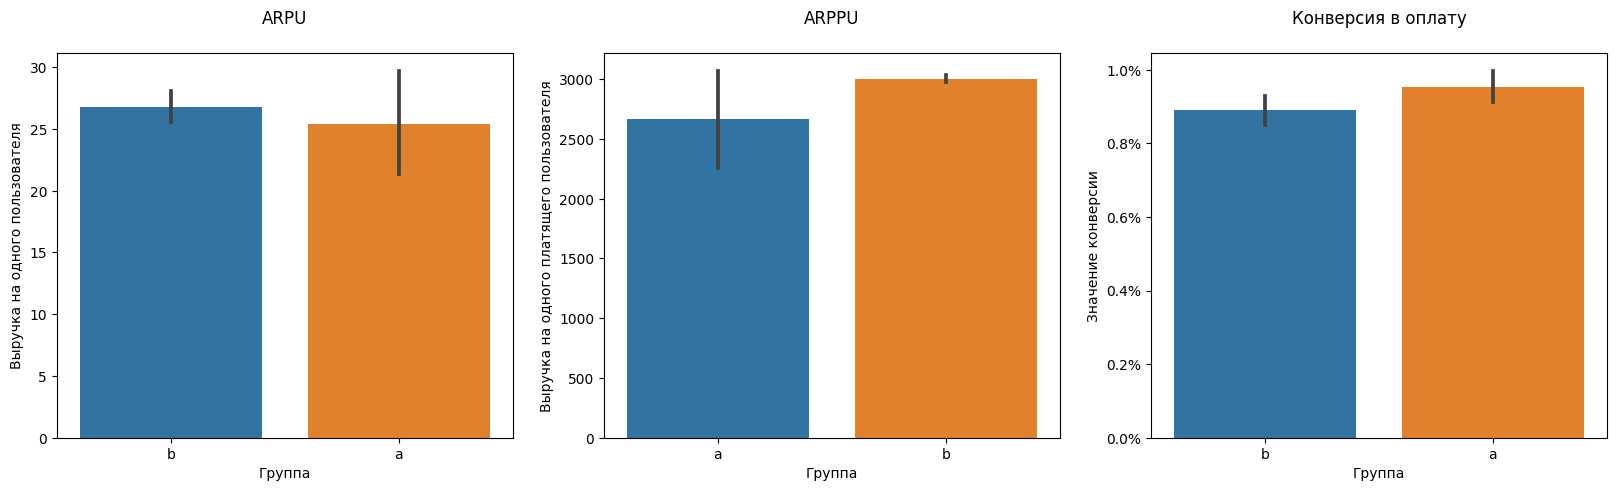

In [19]:
# Визуализируем метрики
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
ax = sns.barplot(x = 'testgroup', y = 'revenue', data = data)
plt.xlabel('Группа')
plt.ylabel('Выручка на одного пользователя')
plt.title('ARPU\n')

plt.subplot(1,3,2)
ax = sns.barplot(x = 'testgroup', y = 'revenue', data = data.query('revenue > 0'))
plt.xlabel('Группа')
plt.ylabel('Выручка на одного платящего пользователя')
plt.title('ARPPU\n')

plt.subplot(1,3,3)
ax = sns.barplot(x = 'testgroup', y = 'pay_users', data = data)
yticks = ax.get_yticks()
ax.set_yticklabels([f'{round(i*100,1)}%' for i in yticks])
plt.xlabel('Группа')
plt.ylabel('Значение конверсии')
plt.title('Конверсия в оплату\n')

plt.show()

После подсчета метрик выявлены различия между тестовой и контрольной группой.

### Метрика ARPU
Перед проведением теста формулируем гипотезы:  
**H0** - различий в ARPU между тестовой и контрольной группах нет.  
**H1** - различия в APRU меду тестовой и контрольной группах есть.

Уровень значимости (**p-value**): определим равным **0.05**

Проверим выборки на нормальность и равенство дисперсий

In [20]:
# Проводим тест для определения нормальности.
pg.normality(data=data, group='testgroup', dv = 'revenue', method = 'normaltest')

,W,pval,normal
testgroup,,,
b,326622.395409,0.0,False
a,585152.731273,0.0,False


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

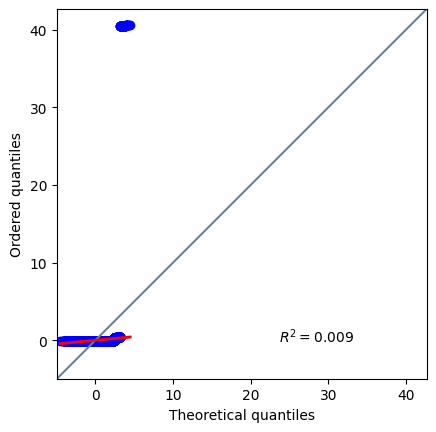

In [21]:
pg.qqplot(data.query('testgroup == "a"').revenue) 

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

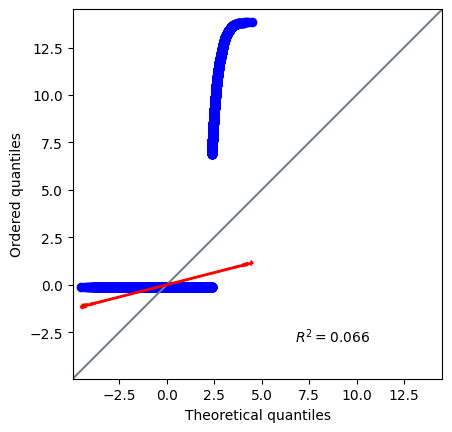

In [22]:
pg.qqplot(data.query('testgroup == "b"').revenue) 

In [23]:
# Проверяем данные на равенство дисперсий
pg.homoscedasticity(data=data, group='testgroup', dv = 'revenue')

,W,pval,equal_var
levene,0.389629,0.532495,True


Для проверки гипотез будем использовать Т-тест Уэлча, так как дисперсии двух выборок равны, а сами выборки большие

In [24]:
control = data.query('testgroup == "a"').revenue
test = data.query('testgroup == "b"').revenue

In [25]:
#Проводим Т-тест Уэлча, так как размеры выборок разные
pg.ttest(control, test, correction = True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Результаты теста показали, что нет **оснований опровергать нулевую гипотезу** о различиях между группами. 

## Метрика ARPPU

**H0** - различий в ARPPU между тестовой и контрольной группах нет.  
**H1** - различия в АRPPU между тестовой и контрольной группах есть.  
**p-value** = 0.05

Проверяем данные на нормальность и гомоскедостичность

In [ ]:
# Для проверки нормальности можно использовать метод Шапиро-Уилка, так как выборка меньше пяти тысяч.
pg.normality(data=data.query('revenue >0'), group='testgroup', dv = 'revenue', method = 'shapiro')

In [ ]:
# Проверяем равенство дисперсий
pg.homoscedasticity(data=data.query('revenue >0'), group='testgroup', dv = 'revenue', method = 'levene')

Для проверки гипотез также используем **Т-тест Уэлча**, так как выборки и их дисперсии не равны.

In [ ]:
control = data.query('revenue > 0 & testgroup == "a"').revenue
test = data.query('revenue > 0 & testgroup == "b"').revenue

In [26]:
pg.ttest(control, test, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Результаты теста показали p-value = 0.1, что **не позволяет отвергнуть нулевую гипотезу.**

### Метрика конверсия в оплату

Для метрики конверсии в оплату использую **критерий Хи-квадрат**, так как в частном случае его можно использовать для анализа конверсий. 

In [27]:
chi_test = pd.crosstab(data.testgroup, data.pay_users)

In [28]:
chi_test

pay_users,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [29]:
stat, p, dof, expected = st.chi2_contingency(chi_test)
print(f"Значение статистики: {stat}.")
print(f"Значение p-value: {p}.")
print(f"Степени свободы: {dof}.")
print(f"Ожидаемое наблюдение: {expected}.")

Значение статистики: 4.374729521260405.
Значение p-value: 0.03647561892312613.
Степени свободы: 1.
Ожидаемое наблюдение: [[200239.10075104   1863.89924896]
 [200797.89924896   1869.10075104]].


Исходя из значения статистической значимости (0.036) можно опровергнуть нулевую гипотезу о равенстве значения конверсии в оплату в двух группах.

Выводы:
1. Для оценки акционных предложений были выбраны метрики ARPU, ARPPU и конверсии в оплату, так как они отражают эффективность монетизации продукта и поведение пользователей на пути к продукту. Они позволяют выявить за счет чего растет прибыль. Таким образом, они помогут выявить эффективность акционных предложений.
2. Выявлено, что значения метрик ARPU и ARPPU в группе Б выше, чем в группе А. Однако проведенные тесты не показали статистически значимых различий.
3. Значение метрики конверсии в оплату в группе А выше, чем в группе Б. Проверка гипотез показала статистически значимый результат, что конверсия в оплату в группе А выше, чем в группе Б.
4. Таким образом, наборы акционных предложений группы А можно считать лучшим, так как значение метрики конверсии в оплату в данной группе выше. Однако, различий между группами между другими ключевыми метриками (ARPU и ARPPU) не выявлено.